Due to the nature of SM, some images that pop up make problems on our readout - here, we try to find them and eliminate them

In [2]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [3]:
from extraction_sm import *
import astroscrappy
import scipy.ndimage as ndimage
from scipy.signal import convolve2d

In [90]:
# Problem children

# has a long column that's definitely a readout feature - causes spurious detections - at AC 68
# this guy has a baseline of about 33000 and a very high variation - like readnoise
# This is actually a hot column! They may appear sometimes, be there from the start or evolve in time.
# I also need to find an get rid of them.
#sourcefile = "../../datasets/sif_fits/2017-09-11/SIF_PROCESSING_CCD_ROW_4_SM1_OBMT_START_122099783998730300_CDP_NONE.fits"

# has stars that STILL cause detections (when flipped, around [600:800,1200:1400])
# even setting objlim or sigclip to really high values does not fix this - I'll lose cosmics
# WAIT. Looking at them with ds9, you see that they're REALLY weird. They don't decay smoothly at all!
# They're all in the same line (e.g. same AL)! Are they some kind of ghost caused by the bright star???
# -> Yes, they are, they appear sometimes, trailing the star. You need to mask them...
sourcefile = "../../datasets/sif_fits/2017-06-30/SIF_PROCESSING_CCD_ROW_5_SM1_OBMT_START_115795370998972700_CDP_NONE.fits"
# SOLVED - see our lower redefinition of sm_starmask

# this one causes crashes while calculating the mean mask - some pixels seem to be very negative
#sourcefile = "../../datasets/sif_fits/2017-09-11/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_122099768999236700_CDP_NONE.fits"
# SOLVED - here, I think that the mean mask cleaning fails due to proximity to a star or an unrecognized cosmic
# SOLUTION: Since these guys can't have a proper error estimation (and quite likely wrong detections), I discard any
#           values where (imbias-clean) < 0
# this also fixes negative energy cosmics

#sourcefile=("../../datasets/sif_fits/2014-01-03/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_5520130998393550_CDP_NONE.fits")

(source,gain,bias,readnoise,fov,row,tstart,tstop) = sm_get_image(sourcefile, "../../datasets/sm_bias/sm_calibdat.fits")
imbias = source-bias
imelec = imbias*gain

starmask = sm_starmask(source,2000)

In [93]:
# to get rid of the electronic ghosts, it's best that I improve my masking algorithm

image = source
threshold = 2000

import numpy as np
from scipy.ndimage import generate_binary_structure
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.measurements import label, find_objects

# occasionally, an overflow for very bright stars causes some pixels to be set to 0
# -> set them to 65535, so they will be masked
image[image==0] = 65535

# initialize the mask to all False
starmask = np.zeros(image.shape, dtype=bool)

# if nothing is saturated, return the starmask
if np.max(image)<65535:
    pass
    #return starmask
else:
    # mask of pixels above threshold
    satmap = np.logical_and(image,image>=threshold)

    # dilate it - sometimes, pixel values fluctuate around the threshold
    satmap = binary_dilation(satmap,iterations=1)

    # labelling all connected pixels
    (starlabels, nstars) = label(satmap,structure=(np.ones((3,3))))

    # we're only interested in the labels of pixels that are saturated
    # so, get all the labels that have that:
    satlabels = np.unique(starlabels[image==65535])

    for lab in satlabels:
        starcoords = np.argwhere(starlabels==lab)
        starmask[starlabels==lab] = 1
        # this star may also cause electronic ghosts at lower AC = x
        # they will have the same central AL, though
        # we can determine that: it's the AL-coordinate of the masked star pixel LOWEST in AC
        edgepix = starcoords[np.where(starcoords[:,1] == np.min(starcoords[:,1]))][0] # first should be accurate enough
        ghostlabels = np.unique(starlabels[edgepix[0],0:edgepix[1]])
        if len(ghostlabels) == 1:
            # Only found 0's, so nothing
            continue
        else:
            for glab in ghostlabels[1:]:
                if np.sum(starlabels[starlabels==glab]/glab) >= 100:
                    starmask[starlabels==glab] = 1
                

    #return starmask - dilate it once (we won't be losing much here)
    starmask = binary_dilation(starmask,iterations=1)

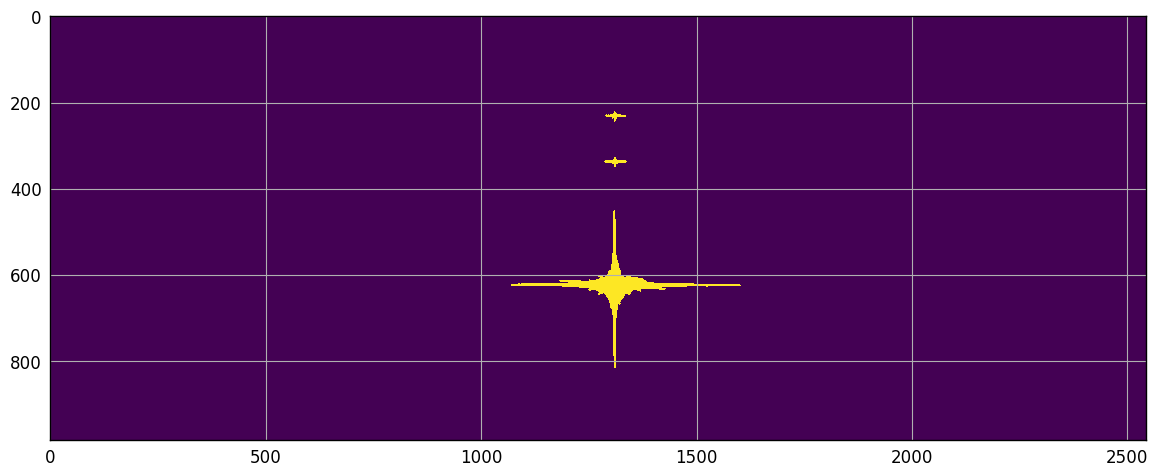

In [94]:
plt.imshow(np.flip(np.rot90(starmask,1),0))
#plt.gcf().set_size_inches(30.5, 5.5)

In [59]:
sigclip=10
sigfrac=0.3
objlim=10

In [60]:
# construct mask with astroscrappy
imbias = np.subtract(source, bias)

# apply scrappy
(mask,clean) = astroscrappy.detect_cosmics(imbias, gain=gain, verbose=False, inmask=starmask, 
                                       satlevel=65535, readnoise=readnoise, sepmed=False, 
                                       cleantype='meanmask', fsmode='median',
                                       sigclip=sigclip, sigfrac=sigfrac, objlim=objlim)

# cosmic signal
signal = ((imbias)*gain - clean)*mask*(1-starmask)
# sometimes, the signal is actually lower than 0 - this is because the mean mask filter overestimated the background
# the median mask filter does better here, but then we have the problem of not being able to work out the uncertainty
# the problem here is that there is most likely a star nearby, and this was either a false detection, or a (very) weak cosmic
# So, there are two ways to solve this:
#  a) identify non-saturated stars and add them to the starmask - not sure how feasible
#  b) just throw them away - negative energy cosmics make no sense anyway
mask[signal<0] = 0
signal[signal<0] = 0


# label cosmics
(labels, ntracks) = ndimage.measurements.label(mask, structure=(np.ones((3,3))))

# object extraction
events = ndimage.measurements.find_objects(labels)

# calculate the uncertainty of the signal (mean mask + counting noise)
# Theoretically we don't even need to calculate err_mean where we don't mask
# but the convolution is much faster than if I were to do it via some loop
err_mean = np.zeros(source.shape)

(xmax, ymax) = source.shape
totmask = starmask+mask    # masked pixels, including stars
totmask[totmask==2]=1      # there should be no overlap, but to be safe
unmasked = (imbias)*gain * (1-totmask)

rad = 2   # i.e. 2 for a 5x5 filter

# We need to count the number of unmasked pixels in the filter and
# the sum of unmasked pixel values in the filter
# This can be done very easily using convolution!

kernel = np.ones((2*rad+1,2*rad+1))

N_unm = convolve2d(1-totmask, kernel, mode="same", boundary="fill", fillvalue=0)
N_unm[N_unm==0]=1            # we'll be dividing by this later - this stops errors

var_mean = convolve2d(unmasked, kernel, mode="same", boundary="fill", fillvalue=0) # sum up everything around
var_mean = (readnoise*readnoise + var_mean/N_unm)/N_unm                            # from error propagation

err_mean = np.sqrt(var_mean + readnoise*readnoise + np.abs(gain*imbias))     # total mean error
# the absolute value mistreats all the values where we're way below the gain due to noise etc.
# there should be no cosmics there, so this is fine


cosmics = []
dimAL = []
dimAC = []
locAL = []
locAC = []
Etots = []
delEtots = []

# fill the data
for ii in range(ntracks):
    # the location
    location = events[ii]
    loc = ((location[0].start, location[1].start))

    # the event (only for this label)
    cosmic = np.copy(signal[location])
    lab = labels[location]
    cosmic[lab!=ii+1] = 0

    # total energy
    Etot = np.rint((np.sum(cosmic)))

    # uncertainty on total energy
    err = np.copy(err_mean[location])
    err[lab!= ii+1] = 0
    delEtot = np.rint((np.sqrt(np.sum(err**2))))

    # turn the cosmic into a flattened array, but save its dimensions
    dim = cosmic.shape
    
    # saving for analysis here
    cosmics.append(cosmic)
    dimAL.append(dim[0])
    dimAC.append(dim[1])
    locAL.append(loc[0])
    locAC.append(loc[1])
    Etots.append(Etot)
    delEtots.append(delEtot)

    
Etots = np.array(Etots)
delEtots = np.array(delEtots)

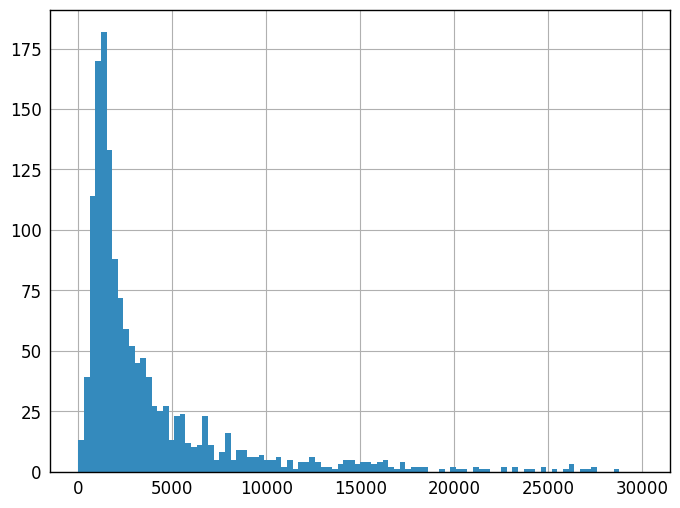

In [61]:
test = plt.hist(Etots,100,range=(0,30000))